In [3]:
pth = '/Users/sph/sphar01@stanford.edu - Google Drive/Shared drives/SLab/k_band/slab_rfsoc_expts-elaine_rfsoc/slab_rfsoc_expts-elaine_rfsoc/setup6/qub_temp_scan20240516_143834/'

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import os
import sys
import json
import cProfile
sys.path.append('/Users/sph/Library/CloudStorage/GoogleDrive-spharvey3@gmail.com/My Drive/Schuster/Code/Git')


from slab.experiment import Experiment
from slab.datamanagement import SlabFile
import experiments.fitting as fitter

"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
    return temp_data, attrs

import experiments as meas 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.twoQ_state_tomography
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomography
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.adiabatic_pulse_calib
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.single_qubit.SingleRB
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t1
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single

In [4]:
fname = '00001_amp_rabi_qubit0.h5'
rdata,attrs = prev_data(pth, fname)


Max phase is 1.2272289369796714
Max freq is 0.0002105263157894737
Max phase is 1.1871448009303218
Max freq is 0.0002105263157894737
Max phase is 1.2600591761220354
Max freq is 0.0002105263157894737
[3.412024391709373, 0.0002105263157894737, 72.19607272852431, 37.99890046858784]
Pi gain from amps data [dac units]: 1670
	Pi/2 gain from amps data [dac units]: 835
Pi gain from avgi data [dac units]: 1684
	Pi/2 gain from avgi data [dac units]: 842
Pi gain from avgq data [dac units]: 1704
	Pi/2 gain from avgq data [dac units]: 852


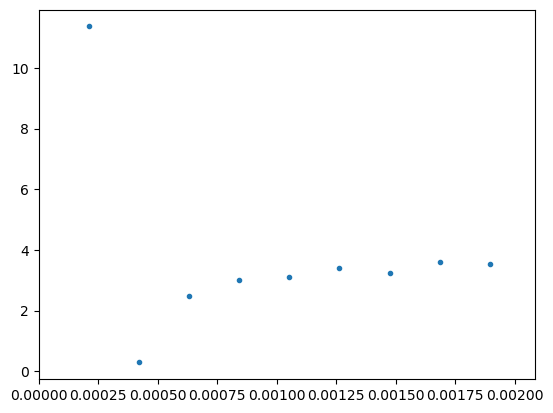

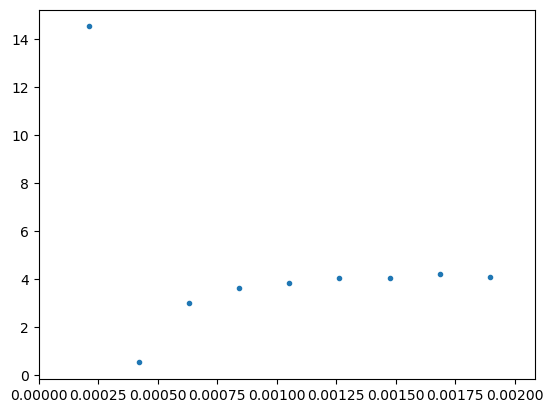

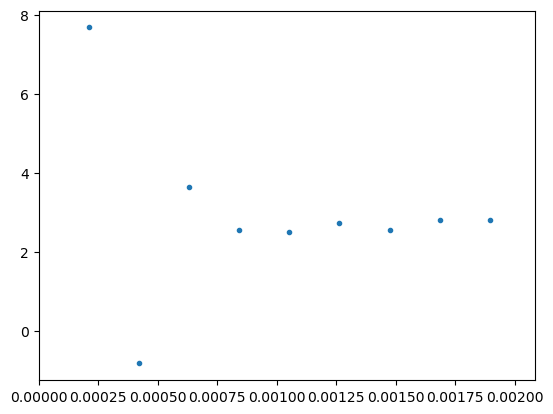

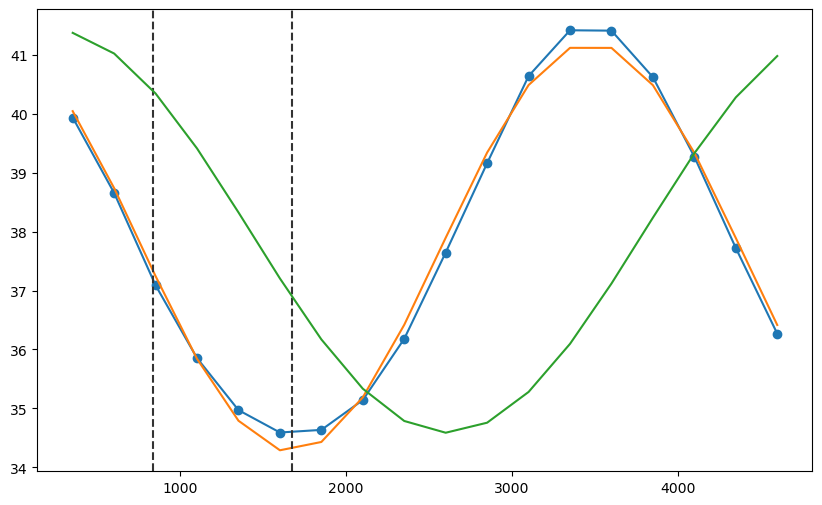

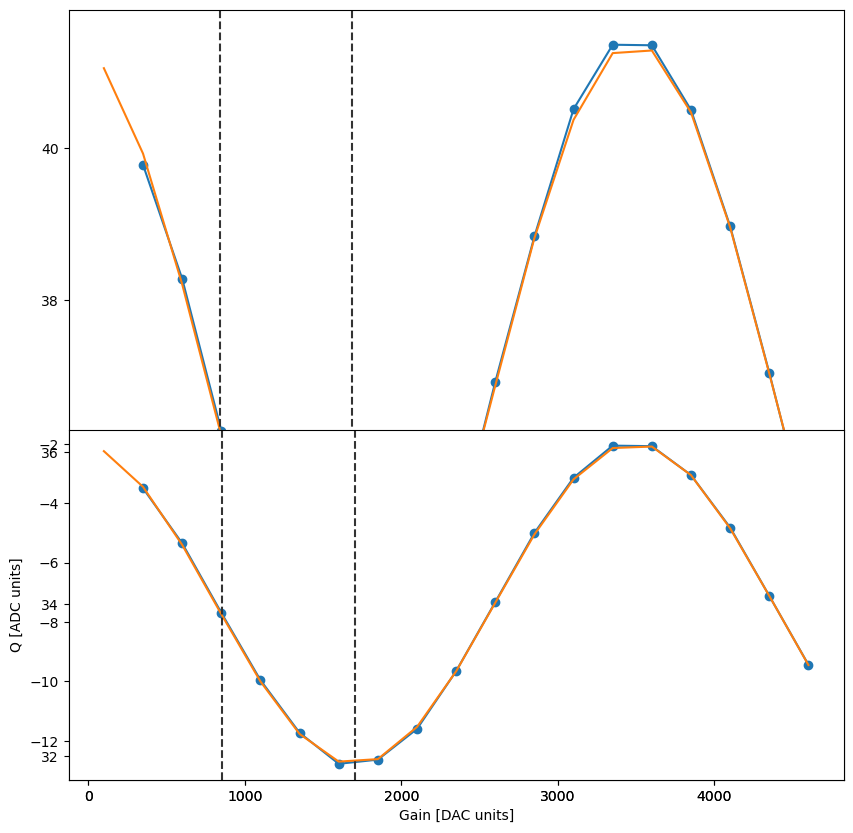

In [20]:
analyze([],rdata, debug=True)
display([],rdata, cfg=attrs['config'], debug=True)

In [8]:
1/3500

0.00028571428571428574

In [15]:

def analyze(self, data=None, fit=True, debug=True, **kwargs):
    if data is None:
        data=self.data
    
    if fit:
        # fitparams=[amp, freq (non-angular), phase (deg), decay time, amp offset]
        # Remove the first and last point from fit in case weird edge measurements
        xdata = data['xpts']
        fitparams=None

        ydata = data["amps"]
        # print(abs(xdata[np.argwhere(ydata==max(ydata))[0,0]] - xdata[np.argwhere(ydata==min(ydata))[0,0]]))
        # fitparams=[max(ydata)-min(ydata), 1/2 / abs(xdata[np.argwhere(ydata==max(ydata))[0,0]] - xdata[np.argwhere(ydata==min(ydata))[0,0]]), None, None, None]
        # fitparams=[max(ydata)-min(ydata), 1/2 / (max(xdata) - min(xdata)), 0, None, None]
        if debug: 
            p_avgi, pCov_avgi, avgi_init = fitter.fitsin(data['xpts'][:-1], data["avgi"][:-1], fitparams=fitparams, debug=debug)
            p_avgq, pCov_avgq, avgq_init = fitter.fitsin(data['xpts'][:-1], data["avgq"][:-1], fitparams=fitparams, debug=debug)
            p_amps, pCov_amps, amps_init = fitter.fitsin(data['xpts'][:-1], data["amps"][:-1], fitparams=fitparams, debug=debug)

            data['fit_avgi_init'] = avgi_init  
            data['fit_avgq_init'] = avgq_init
            data['fit_amps_init'] = amps_init
        else:
            p_avgi, pCov_avgi = fitter.fitsin(data['xpts'][:-1], data["avgi"][:-1], fitparams=fitparams)
            p_avgq, pCov_avgq = fitter.fitsin(data['xpts'][:-1], data["avgq"][:-1], fitparams=fitparams)
            p_amps, pCov_amps = fitter.fitsin(data['xpts'][:-1], data["amps"][:-1], fitparams=fitparams)

        data['fit_avgi'] = p_avgi   
        data['fit_avgq'] = p_avgq
        data['fit_amps'] = p_amps



        data['fit_err_avgi'] = pCov_avgi   
        data['fit_err_avgq'] = pCov_avgq
        data['fit_err_amps'] = pCov_amps

        p = data['fit_avgi']     
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: 
            pi_length = (1/2 - p[2]/180)/2/p[1]
        else: 
            pi_length= (3/2 - p[2]/180)/2/p[1]
        data['pi_length']=pi_length

    return data

def display(self, data=None, fit=True, cfg=None, debug=False, **kwargs):
    if data is None:
        data=self.data 

    if cfg is None: 
        cfg = self.cfg
    
    # if cfg['expt']['checkZZ']: # [x, 1] means test Q1 with ZZ from Qx; [1, x] means test Qx with ZZ from Q1, sort by Qx in both cases
    #     assert len(self.qubits) == 2
    #     assert 1 in self.qubits
    #     qZZ, qTest = self.qubits
    #     qSort = qZZ # qubit by which to index for parameters on qTest
    #     if qZZ == 1: qSort = qTest
    # else: qTest = cfg['expt'][qubits[0]]

    plt.figure(figsize=(10, 6))
    #title = f"Amplitude Rabi on Q{qTest} (Pulse Length {self.cfg.expt.sigma_test}{(', ZZ Q'+str(qZZ)) if self.checkZZ else ''})"
    #plt.subplot(111, title=title, xlabel="Gain [DAC units]", ylabel="Amplitude [ADC units]")
    plt.plot(data["xpts"][1:-1], data["amps"][1:-1],'o-')
    if fit:
        p = data['fit_amps']
        plt.plot(data["xpts"][1:-1], fitter.sinfunc(data["xpts"][1:-1], *p))
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain= (3/2 - p[2]/180)/2/p[1]
        pi2_gain = pi_gain/2
        print(f'Pi gain from amps data [dac units]: {int(pi_gain)}')
        print(f'\tPi/2 gain from amps data [dac units]: {int(pi2_gain)}')
        plt.axvline(pi_gain, color='0.2', linestyle='--')
        plt.axvline(pi2_gain, color='0.2', linestyle='--')
    if debug: 
        plt.plot(data["xpts"][1:-1], fitter.sinfunc(data["xpts"][1:-1], *data['fit_amps_init']))
    plt.figure(figsize=(10,10))
    #plt.subplot(211, title=title, ylabel="I [ADC units]")
    plt.plot(data["xpts"][1:-1], data["avgi"][1:-1],'o-')
    # plt.axhline(390)
    # plt.axhline(473)
    # plt.axvline(2114)
    # plt.axvline(3150)
    if fit:
        p = data['fit_avgi']
        plt.plot(data["xpts"][0:-1], fitter.sinfunc(data["xpts"][0:-1], *p))
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain= (3/2 - p[2]/180)/2/p[1]
        pi2_gain = pi_gain/2
        print(f'Pi gain from avgi data [dac units]: {int(pi_gain)}')
        print(f'\tPi/2 gain from avgi data [dac units]: {int(pi2_gain)}')
        plt.axvline(pi_gain, color='0.2', linestyle='--')
        plt.axvline(pi2_gain, color='0.2', linestyle='--')
    plt.subplot(212, xlabel="Gain [DAC units]", ylabel="Q [ADC units]")
    plt.plot(data["xpts"][1:-1], data["avgq"][1:-1],'o-')
    if fit:
        p = data['fit_avgq']
        plt.plot(data["xpts"][0:-1], fitter.sinfunc(data["xpts"][0:-1], *p))
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain= (3/2 - p[2]/180)/2/p[1]
        pi2_gain = pi_gain/2
        print(f'Pi gain from avgq data [dac units]: {int(pi_gain)}')
        print(f'\tPi/2 gain from avgq data [dac units]: {int(pi2_gain)}')
        plt.axvline(pi_gain, color='0.2', linestyle='--')
        plt.axvline(pi2_gain, color='0.2', linestyle='--')

    plt.show()